### K10지수 산출
  + 엑셀로 실습했던 내용을 파이썬으로 구현
  + 네이버에서 데이터 스크레이핑 진행
  + 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=005930' 활용


In [1]:
# 패키지 불러오기
import sys
import os
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime as dt
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fname = fm.FontProperties(fname='D:/data_starfish/jupyter/malgun.ttf').get_name()
from IPython.display import Image
mpl.rc('font',family=fname)
import matplotlib.gridspec as gridspec
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
%matplotlib inline
import platform
platform.system()
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

In [2]:
url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=005930'
source = urlopen(url_float).read()
soup = BeautifulSoup(source, 'lxml')

In [3]:
# XPath => //*[@id="cTB11"]/tbody/tr[7]/td
temp = soup.find(id="cTB11").find_all('tr')[6].td.text
temp = temp.replace('\r','')
temp = temp.replace('\n','')
temp = temp.replace('\t','')
temp

'5,969,782,550주 / 74.62%'

In [4]:
# 정규표현식
import re
temp = re.split('/', temp)
temp

['5,969,782,550주 ', ' 74.62%']

In [5]:
temp[0]

'5,969,782,550주 '

In [6]:
temp[1]

' 74.62%'

In [7]:
# 상장주식수는 outstanding, 유동비율은 floating 변수에 저장
# outstanding => int , floating => float 형태로 저장
outstanding = temp[0].replace(',','')
outstanding = outstanding.replace('주','')
outstanding = outstanding.replace(' ','')
outstanding = int(outstanding)
outstanding

5969782550

In [8]:
# %기호는 지워줌
floating = temp[1].replace(' ','')
floating = floating.replace('%','')
floating = float(floating)
floating

74.62

In [9]:
# 함수화

def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = BeautifulSoup(source, 'lxml')
    
    temp = soup.find(id="cTB11").find_all('tr')[6].td.text
    temp = temp.replace('\r','')
    temp = temp.replace('\n','')
    temp = temp.replace('\t','')
    
    temp = re.split('/', temp)
    
    outstanding = temp[0].replace(',','')
    outstanding = outstanding.replace('주','')
    outstanding = outstanding.replace(' ','')
    outstanding = int(outstanding)
    
    floating = temp[1].replace(' ','')
    floating = floating.replace('%','')
    floating = float(floating)
    
    name = soup.find(id="pArea").find('div').find('div').find('tr').find('td').find('span').text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name

In [10]:
# k10 지수 구성종목
'''
한국거래소 시가총액 상위 10종목 (2020년 12월 기준)
005930 삼성전자
000660 SK하이닉스
051910 LG화학
005935 삼성전자(우)
207940 삼성바이오로직스
068270 셀트리온
035420 NAVER
005380 현대차
006400 삼성SDI
035720 카카오
'''

k10_component = ['005930','000660','051910','005935',
                 '207940','068270','035420','005380',
                 '006400','035720']

In [11]:
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()
for stock_cd in k10_component:
    stock_info(stock_cd)

In [12]:
k10_outstanding

{'005930': 5969782550,
 '000660': 728002365,
 '051910': 70592343,
 '005935': 5969782550,
 '207940': 66165000,
 '068270': 134997805,
 '035420': 164263395,
 '005380': 213668187,
 '006400': 68764530,
 '035720': 88310279}

In [13]:
k10_floating

{'005930': 74.62,
 '000660': 73.74,
 '051910': 64.29,
 '005935': 74.62,
 '207940': 24.75,
 '068270': 75.71,
 '035420': 78.18,
 '005380': 64.1,
 '006400': 73.24,
 '035720': 71.63}

----

#### 종가 구하기

In [14]:
# 우선 이전에 정의한 date_format 함수 재정의
def date_format(d):
    d = str(d).replace('-','.')
    yyyy = int(d.split('.')[0])
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])
    
    this_date = dt.date(yyyy, mm, dd)
    return this_date

def date_format(d=''):
    if d != '':
        this_date = pd.to_datetime(d).date()
    else:
        this_date = pd.Timestamp.today().date()
    return (this_date)

In [15]:
# 과거 주가(종가) 구하기
# 기존에 작성했던 코드를 변형해서 사용 (페이지 구조가 비슷하므로)

def historical_stock_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   
        start_date = date_format(start_date)   
    else:    
        start_date = dt.date.today() 
    if end_date:   
        end_date = date_format(end_date)   
    else:   
        end_date = dt.date.today()  
        
        
    naver_stock = \
    'https://finance.naver.com/item/sise_day.nhn?code=' \
    + stock_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    source = BeautifulSoup(source, 'lxml')   
    
    dates = source.find_all('span', class_='tah p10 gray03')  
    prices = source.find_all('td', class_='num')
    
    for n in range(len(dates)):
        
        if len(dates) > 0:
            
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   

                this_close = prices[n*6].text
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   

                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find_all('table')[1].find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page) 
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_stock_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices

In [16]:
k10_historical_prices = dict()

for stock_cd in k10_component:
    
    historical_prices = dict()
    start_date = '2020-1-1'
    end_date = '2020-12-15'
    historical_stock_naver(stock_cd, start_date, end_date)
    
    k10_historical_prices[stock_cd] = historical_prices

In [17]:
# 데이터프레임으로 변환

k10_historical_price = pd.DataFrame(k10_historical_prices)
k10_historical_price.sort_index(axis=1, inplace=True)

In [18]:
k10_historical_price = k10_historical_price.fillna(method='bfill')
if k10_historical_price.isnull().values.any():
    k10_historical_price = k10_historical_price.fillna(method='ffill')
    
k10_historical_price.head(3)

,000660,005380,005930,005935,006400,035420,035720,051910,068270,207940
2020-12-15,117500.0,188500.0,73800.0,69500.0,552000.0,283000.0,371000.0,801000.0,360000.0,800000.0
2020-12-14,117000.0,189000.0,73800.0,69900.0,549000.0,286000.0,373500.0,793000.0,357500.0,812000.0
2020-12-11,115500.0,190000.0,73400.0,69300.0,556000.0,290000.0,374500.0,808000.0,361000.0,820000.0


#### 고려해야할 점1
  + 삼성전자의 경우 2018년 5월 4일부로 1/50 액면분할 실시
  + 따라서 2018/5/4 이전의 주가를 50으로 나눈 수정주가를 활용해야함 (이 기간을 포함하는 데이터를 활용한다면)

In [19]:
# 데이터프레임화
temp = {'Outstanding': k10_outstanding,
       'Floating': k10_floating,
       'Price': k10_historical_price.iloc[0],
       'Name': k10_name}
k10_info = pd.DataFrame(temp)

#### 고려해야할 점2
  + 일반적으로 시가총액(market capitalization)은 '주식 X 상장주식 수'를 뜻함
  + 하지만, 지수를 만들 때는 유동비율을 반영한 시가총액(market capitalization with floating ratio)을 활용함
  + 그러므로 시가총액 => Market Cap, 유동시가총액 => f Market Cap에 따로 저장해본다

In [20]:
k10_info['Market Cap'] = k10_info['Outstanding'] *\
k10_info['Price'] * 0.01

k10_info['f Market Cap'] = k10_info['Outstanding'] *\
k10_info['Floating'] * k10_info['Price'] * 0.01

k10_info.head(3)

,Outstanding,Floating,Price,Name,Market Cap,f Market Cap
000660,728002365,73.74,117500.0,SK하이닉스,8.554028e+11,6.307740e+13
005380,213668187,64.10,188500.0,현대차,4.027645e+11,2.581721e+13
005930,5969782550,74.62,73800.0,삼성전자,4.405700e+12,3.287533e+14


In [21]:
# 날짜별로 시가총액 게산
k10_historical_mc = k10_historical_price * k10_info['Outstanding'] *\
k10_info['Floating'] * 0.01
k10_historical_mc.head(5)

,000660,005380,005930,005935,006400,035420,035720,051910,068270,207940
2020-12-15,6.307740e+13,2.581721e+13,3.287533e+14,3.095983e+14,2.780045e+13,3.634318e+13,2.346822e+13,3.635244e+13,3.679446e+13,1.310067e+13
2020-12-14,6.280899e+13,2.588569e+13,3.287533e+14,3.113802e+14,2.764936e+13,3.672844e+13,2.362636e+13,3.598937e+13,3.653894e+13,1.329718e+13
2020-12-11,6.200374e+13,2.602265e+13,3.269714e+14,3.087074e+14,2.800191e+13,3.724213e+13,2.368962e+13,3.667012e+13,3.689667e+13,1.342819e+13
2020-12-10,6.254057e+13,2.622809e+13,3.247441e+14,3.020254e+14,2.820336e+13,3.672844e+13,2.343659e+13,3.707858e+13,3.679446e+13,1.341181e+13
2020-12-09,6.468789e+13,2.622809e+13,3.291988e+14,2.980162e+14,2.850554e+13,3.698528e+13,2.372124e+13,3.794087e+13,3.613012e+13,1.346094e+13


In [22]:
# 지수 구성종목 각각의 시가총액을 더해서 K10 지수의 일자별 시가총액을 구함
'''
<데이터프레임>.sum()은 각 열의 합 (세로 방향)
<데이터프레임>.sum(axis=1)은 각 행의 합 (가로 방향)
'''
k10_historical_mc.sum(axis=1)

2020-12-15    9.011056e+14
2020-12-14    9.026578e+14
2020-12-11    8.996338e+14
2020-12-10    8.911914e+14
2020-12-09    8.948749e+14
                  ...     
2020-01-08    6.118841e+14
2020-01-07    6.060644e+14
2020-01-06    6.002194e+14
2020-01-03    6.008608e+14
2020-01-02    6.004606e+14
Length: 238, dtype: float64

In [23]:
# 데이터프레임화
k10 = pd.DataFrame()
k10['K10 Market Cap'] = k10_historical_mc.sum(axis=1)
k10.head(3)

,K10 Market Cap
2020-12-15,9.011056e+14
2020-12-14,9.026578e+14
2020-12-11,8.996338e+14


In [24]:
# 지수 산출
k10['K10'] = k10['K10 Market Cap'] / k10['K10 Market Cap'].loc[dt.date(2020, 1, 2)] * 100
k10.head(3)

,K10 Market Cap,K10
2020-12-15,9.011056e+14,150.069075
2020-12-14,9.026578e+14,150.327570
2020-12-11,8.996338e+14,149.823963


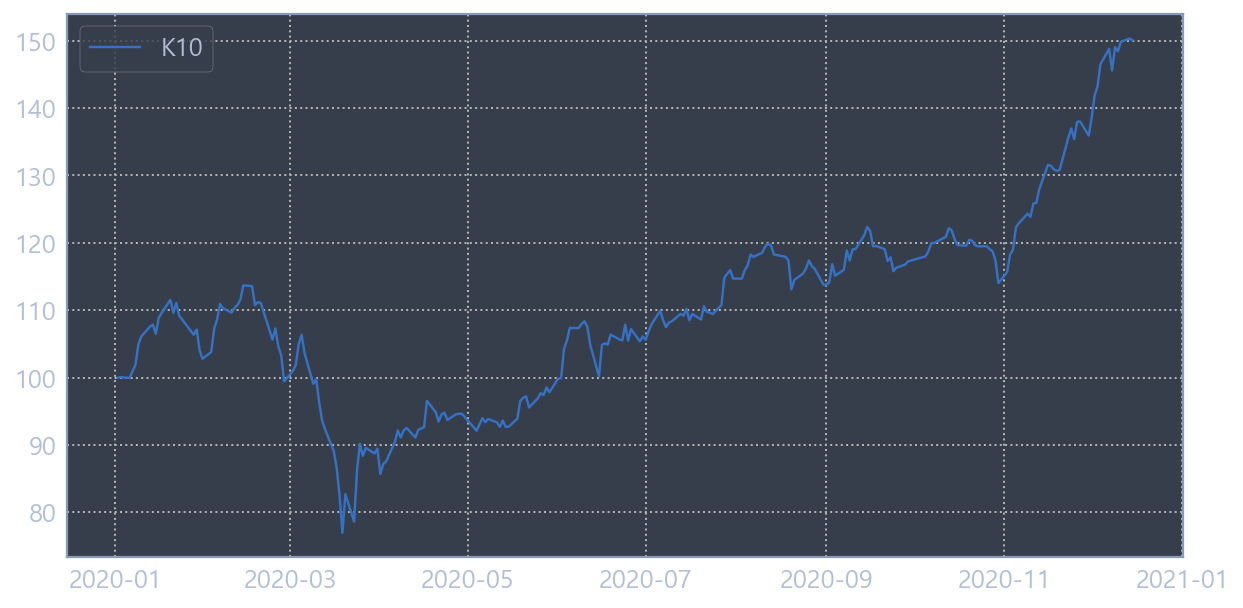

In [25]:
# 그래프 그리기
plt.figure(figsize=(10,5))
plt.plot(k10['K10'])
plt.legend(['K10'], loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

In [26]:
# KOSPI200과 비교
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:   
        start_date = date_format(start_date)   
    else:    
        start_date = dt.date.today() 
    if end_date:   
        end_date = date_format(end_date)   
    else:   
        end_date = dt.date.today()  
        
        
    naver_index = \
    'http://finance.naver.com/sise/sise_index_day.nhn?code=' \
    + index_cd + '&page=' + str(page_n)
    
    # 지정한 페이지에서 코드 읽기
    source = urlopen(naver_index).read()
    # 뷰티풀 스프로 태그별로 코드 분류
    source = BeautifulSoup(source, 'lxml')   
    
    # <td class="date">태그에서 날짜 수집   
    dates = source.find_all('td', class_='date')  
    # <td class="number_1">태그에서 지수 수집
    prices = source.find_all('td', class_='number_1')  
    
    for n in range(len(dates)):
    
        if dates[n].text.split('.')[0].isdigit():
            
            # 날짜 처리
            this_date = dates[n].text
            this_date= date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:   
            # start_date와 end_date 사이에서 데이터 저장
                # 종가 처리
                this_close = prices[n*4].text   # 0,4,8...
                this_close = this_close.replace(',', '')
                this_close = float(this_close)

                # 딕셔너리에 저장
                historical_prices[this_date] = this_close
                
            elif this_date < start_date:   
            # start_date 이전이면 함수 종료
                return historical_prices              
            
    # 페이지 네비게이션
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        # 마지막페이지 주소 추출
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page) 
        
    # 다음 페이지 호출
    if page_n < last_page:   
        page_n = page_n + 1   
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)   
        
    return historical_prices

In [27]:
historical_prices = dict()
kospi200 = historical_index_naver('KPI200', '2020-1-1', '2020-12-15')
kospi200

{datetime.date(2020, 12, 15): 370.88,
 datetime.date(2020, 12, 14): 371.56,
 datetime.date(2020, 12, 11): 372.24,
 datetime.date(2020, 12, 10): 369.37,
 datetime.date(2020, 12, 9): 371.47,
 datetime.date(2020, 12, 8): 363.45,
 datetime.date(2020, 12, 7): 369.86,
 datetime.date(2020, 12, 4): 367.63,
 datetime.date(2020, 12, 3): 361.66,
 datetime.date(2020, 12, 2): 358.66,
 datetime.date(2020, 12, 1): 352.4,
 datetime.date(2020, 11, 30): 346.05,
 datetime.date(2020, 11, 27): 352.73,
 datetime.date(2020, 11, 26): 352.12,
 datetime.date(2020, 11, 25): 348.3,
 datetime.date(2020, 11, 24): 350.28,
 datetime.date(2020, 11, 23): 348.46,
 datetime.date(2020, 11, 20): 340.62,
 datetime.date(2020, 11, 19): 340.16,
 datetime.date(2020, 11, 18): 339.96,
 datetime.date(2020, 11, 17): 339.85,
 datetime.date(2020, 11, 16): 340.63,
 datetime.date(2020, 11, 13): 333.03,
 datetime.date(2020, 11, 12): 329.72,
 datetime.date(2020, 11, 11): 331.12,
 datetime.date(2020, 11, 10): 326.13,
 datetime.date(2020, 

In [28]:
# 데이터프레임화
k200 = pd.DataFrame({'K200': kospi200})
k200.head(3)

,K200
2020-01-02,290.35
2020-01-03,290.74
2020-01-06,288.43


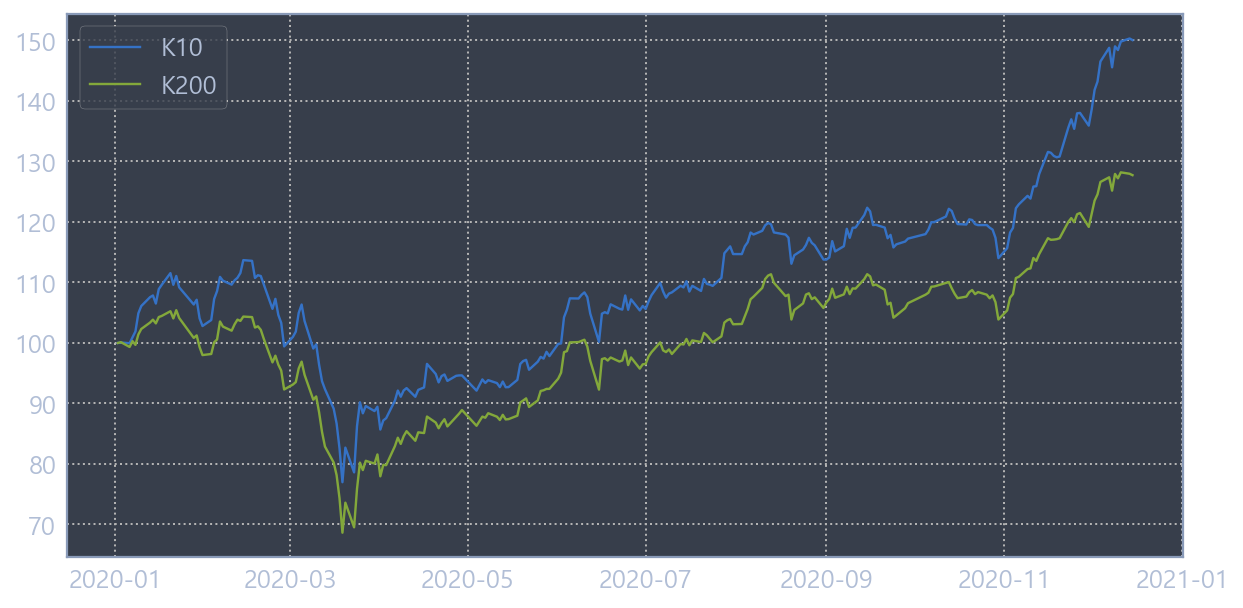

In [29]:
plt.figure(figsize=(10,5))
plt.plot(k10['K10'] / k10['K10'].loc[dt.date(2020, 1, 2)] * 100)
plt.plot(k200['K200'] / k200['K200'].loc[dt.date(2020, 1, 2)] * 100)                     
plt.legend(['K10','K200'], loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

# 상위10개 종목이 주식시장 상승을 주도했다는 것을 알 수 있음